In [2]:
!pip install ta

You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install datetime

You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install pandas_datareader

You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import ta as ta
import warnings
import sys, os
import datetime

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


In [6]:
UST = 'https://raw.githubusercontent.com/black-swan-2/Black-Swan-2-Models/master/Data/USTREASURY-YIELD.csv'
FRED_PERMIT = 'https://raw.githubusercontent.com/black-swan-2/Black-Swan-2-Models/master/Data/FRED-PERMIT.csv'
ISMVS_GDP = 'https://raw.githubusercontent.com/black-swan-2/Black-Swan-2-Models/master/Data/ismvsgdp.csv'
USLGI = 'https://raw.githubusercontent.com/black-swan-2/Black-Swan-2-Models/master/Data/USLgI.csv'
INVERSION = 'https://raw.githubusercontent.com/black-swan-2/Black-Swan-2-Models/master/Data/inversion.csv'


In [7]:
def get_data():
    """
    Downloads and wrangles data for BlackSwan 2.0 VIX modeling. 
  
    Combines the two index datasets and creates a 
    new DataFrame (df) that contains the target feature (Trading Days with 3 
    STDV shifts based on a rolling window)
  
    :input: vix  => CBOE VIX Historical Data
    :input: gspc => GSPC S&P 500 index with matching start date to VIX
  
    :return: df  => cominbation VIX/GSPC Dataset with Target Classifier 
    """
  
    ############### Getting Data ##################
  
    vix = (data.DataReader('^VIX', 
                           "yahoo", 
                           start='1990-1-02', 
                           end='2019-5-31')
           .drop(columns = ['Volume', 'Adj Close']))
  
    gspc = data.DataReader('^GSPC', 
                           "yahoo", 
                           start='1990-1-02',
                           end='2019-5-31')
    
    treasury = (pd.read_csv(UST)
                .sort_values(by = 'Date')
                .drop(columns=['1 MO', '2 MO', '20 YR']))
    
    fred = pd.read_csv(FRED_PERMIT)
    
    ism = pd.read_csv(ISMVS_GDP).drop(index = [0,1])
    
    lag = pd.read_csv(USLGI)
    
    inv = (pd.read_csv(INVERSION)
           [['Date','3m1s_inversion','3m2s_inversion',
             '2s10s_inversion','2s30s_inversion']])
  
    ############### Wrangling Data #################
    
    # Rename the Columns
    vix.columns      = ['vix_high', 'vix_low', 'vix_open', 'vix_close']
    gspc.columns     = ['gspc_high', 'gspc_low', 'gspc_open',
                        'gspc_close','gspc_volume','gspc_adj_close']
  
    # Join the VIX and GSPC
    df = vix.join(gspc)
  
    # Pull Date columns out of the index
    df = df.reset_index()
    
    # Merge DF with the Treasury Data on the Date Feature
    # Date needs to be converted to Datetime format to match df['Date']
    treasury['Date'] = pd.to_datetime(treasury['Date'],
                                      infer_datetime_format=True)
    
    df = pd.merge(df, treasury, how='inner', on='Date')
    
    # Merge DF with the Inversion Features Engineered by Damerei
    # Sort and create key for merging
    inv = inv[inv['Date'] < '2019-06-01'].sort_values(by='Date')
    inv['Date'] = pd.to_datetime(inv['Date'], infer_datetime_format=True)
    
    df = pd.merge(df, inv, how='inner', on='Date')
    
    # A new feature is needed to act as a key for the following features
    df['y/m'] = df['Date'].map(lambda x: x.strftime('%Y-%m'))
    
    # Line up the Date column with the new key for the FRED Data
    fred = fred[fred['Date'] > '1989-12-01'].sort_values(by='Date')
    fred['Date'] = pd.to_datetime(fred['Date'], infer_datetime_format=True)
    fred['Date'] =  fred['Date'].map(lambda x: x.strftime('%Y-%m'))
    
    # Line up the Date column iwth the new key for the ISM/GDP Data
    ism = ism[ism['ticker'] > '1989-12-01'].sort_values(by='ticker')
    ism['ticker'] = pd.to_datetime(ism['ticker'], infer_datetime_format=True)
    ism['ticker'] =  ism['ticker'].map(lambda x: x.strftime('%Y-%m'))
    # Add most recent ISM data
    ism = (ism.append(pd.DataFrame([['2019-04', 52.8, np.nan]
                                   ,['2019-05', 52.1,np.nan]]
                                   ,columns=ism.columns))
           .reset_index()
           .drop(columns='index'))
    #Add most recent GDP Value
    ism['GDP CURY Index'].iloc[351] = 5.0
    # Fill in Quarterly GDP values
    ism = ism.fillna(method='ffill').fillna(method='bfill')
    
    # Wrangle the date column for the Lagging Index Dataframe
    lag['Date'] = pd.to_datetime(lag['Date'], format='%b-%y')
    #Create a pivot point around 2019 to accomodate the 2-digit year format
    for i in np.arange(len(lag)):
        if lag['Date'][i].year > 2019:
            lag['Date'][i] = lag['Date'][i].replace(year=lag['Date'][i].year-100)
        else:
            pass
    # Map to the y/m key format
    lag['Date'] =  lag['Date'].map(lambda x: x.strftime('%Y-%m'))
    #Slice the dataframe to relevant time period
    lag = lag[lag['Date'] > '1989-12']
    

    # Create New Columns with a single iteration using list comprehension
    f  = []
    m  = []
    g  = []
    ll = []
    lg = []

    for i in np.arange(len(df)):
        # Merge the New Private Housing Units Authorized by Building Permits (FRED)
        f.append(float(fred.loc[fred['Date'] == df['y/m'][i]]['Value']
                       .values
                       .tolist()[0]))
        
        # Merge the ISM NAPMPMI Index
        m.append(float(ism.loc[ism['ticker'] == df['y/m'][i]]['NAPMPMI Index']
                       .values
                       .tolist()[0]))
        
        # Merge the GDP CURY Index
        g.append(float(ism.loc[ism['ticker'] == df['y/m'][i]]['GDP CURY Index']
                       .values
                       .tolist()[0]))
        
            # Merge the Lagging Index Level Column
        ll.append(float(lag.loc[lag['Date'] == df['y/m'][i]]['Level']
                        .values
                        .tolist()[0]))
        
        # Merge the Lagging Index Growth Column
        lg.append(float(lag.loc[lag['Date'] == df['y/m'][i]]['Growth']
                        .values
                        .tolist()[0]))
    
    df['lag_index_level'] = ll
    df['lag_index_growth'] = lg
    df['fred'] = f
    df['ism'] = m
    df['gdp_cury'] = g
    
  
    ############### Momemntum Feature Engineering ################
  
    # Awesome Oscillator
    df['mom_ao']=ta.momentum.ao(df['gspc_high'],
                                df['gspc_low'],
                                s=5,len=34,
                                fillna=True)

    # Money Flow Index
    df['mom_mf']=ta.momentum.money_flow_index(df['gspc_high'],
                                              df['gspc_low'],
                                              df['gspc_close'],
                                              df['gspc_volume'],
                                              n=14,fillna=True)
  
    # Relative Strength Index
    df['mom_rsi'] = ta.momentum.rsi(df['gspc_close'],
                                    n=14,
                                    fillna=True)
  
    # Stochasitc Oscillator
    df['mom_stoch']=ta.momentum.stoch(df['gspc_high'],
                                      df['gspc_low'],
                                      df['gspc_close'],
                                      n=14,
                                      fillna=True)
  
    # Stochasitc Signal
    df['mom_st_sig']=ta.momentum.stoch_signal(df['gspc_high'],
                                              df['gspc_low'],
                                              df['gspc_close'],
                                              n=14,
                                              d_n=3,
                                              fillna=True)
  
    # True Strength Indicator
    df['mom_tsi'] = ta.momentum.tsi(df['gspc_close'],
                                    r=25,
                                    s=13,
                                    fillna=True)
  
    # Ultimate Oscillator
    df['mom_uo'] = ta.momentum.uo(df['gspc_high'],
                                  df['gspc_low'],
                                  df['gspc_close'], 
                                  s=7, 
                                  m=14, 
                                  len=28, 
                                  ws=4.0, 
                                  wm=2.0, 
                                  wl=1.0,
                                  fillna=True)
  
    # Williams %R
    df['mom_wr']=ta.momentum.wr(df['gspc_high'],
                                df['gspc_low'],
                                df['gspc_close'],
                                lbp=14,fillna=True)
  
    ############### Volume Feature Engineering ####################
  
    # Accumulation/Distribution Index
    df['vol_adi']=ta.volume.acc_dist_index(df['gspc_high'],
                                           df['gspc_low'],
                                           df['gspc_close'],
                                           df['gspc_volume'],
                                           fillna=True)
  
    # Chaikin Money Flow
    df['vol_cmf'] = ta.volume.chaikin_money_flow(df['gspc_high'],
                                                 df['gspc_low'],
                                                 df['gspc_close'],
                                                 df['gspc_volume'],
                                                 n=20,fillna=True)
  
    # Ease of Movement
    df['vol_eom'] = ta.volume.ease_of_movement(df['gspc_high'],
                                               df['gspc_low'],
                                               df['gspc_close'],
                                               df['gspc_volume'],
                                               n=20,fillna=True)
  
    # Force Index
    df['vol_fm'] = ta.volume.force_index(df['gspc_close'],
                                         df['gspc_volume'],
                                         n=2,fillna=True)
  
    # Negative Volume Index
    df['vol_nvi'] = ta.volume.negative_volume_index(df['gspc_close'],
                                                    df['gspc_volume'],
                                                    fillna=True)
  
    # On-Balance Volume
    df['vol_obv'] = ta.volume.on_balance_volume(df['gspc_close'],
                                                df['gspc_volume'],
                                                fillna=True)
  
    # Volume-Price Trend
    df['vol_vpt'] = ta.volume.volume_price_trend(df['gspc_close'],
                                                 df['gspc_volume'],
                                                 fillna=True)
    
    ############### Volatility Feature Engineering
    
    #Average True Range
    df['atr_low'] = ta.volatility.average_true_range(df['gspc_high'],
                                                     df['gspc_low'],
                                                     df['gspc_close'],
                                                     n=23)
    
    df['atr_high'] = ta.volatility.average_true_range(df['gspc_high'],
                                                      df['gspc_low'],
                                                      df['gspc_close'],
                                                      n=37)

    ############### Target Creation #################
    
   
     # Determine daily market movement between Close and Close
    df['vix_move']  = (1 - df['vix_close']
                       .shift(1)/df['vix_close'])
  
    df['gspc_move'] = (1 - df['gspc_close']
                        .shift(1)/df['gspc_close'])
  
    ############## Handling Null Values ##################
    
    # Interpolating the Null Values for 30yr Treasury Bonds
    df['30 YR'] = (df['30 YR'].interpolate(method='spline',
                                           order=4))

    # Drop the rest
    df = df.dropna()
    
    # Reset the index for mistake free slicing
    df = df.reset_index().drop(columns = 'index')
  
    return df
  

In [8]:
df = get_data()

In [9]:
df.head()

,Date,vix_high,vix_low,vix_open,vix_close,gspc_high,gspc_low,gspc_open,gspc_close,gspc_volume,gspc_adj_close,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,30 YR,3m1s_inversion,3m2s_inversion,2s10s_inversion,2s30s_inversion,y/m,lag_index_level,lag_index_growth,fred,ism,gdp_cury,mom_ao,mom_mf,mom_rsi,mom_stoch,mom_st_sig,mom_tsi,mom_uo,mom_wr,vol_adi,vol_cmf,vol_eom,vol_fm,vol_nvi,vol_obv,vol_vpt,atr_low,atr_high,vix_move,gspc_move
0,1990-01-03,18.190001,18.190001,18.190001,18.190001,360.589996,357.890015,359.690002,358.760010,192330000,358.760010,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,8.04,True,False,False,False,1990-01,102.5,0.5,1748.0,47.2,6.4,0.000000,0.000000,0.000000,78.745764,89.372882,-100.000000,0.970766,-21.254236,9.368614e+07,0.264351,4.780031e-08,0.000000e+00,1000.000000,-192330000.0,-1.152928e+08,14.745670,14.952844,0.052227,-0.002592
1,1990-01-04,19.219999,19.219999,19.219999,19.219999,358.760010,352.890015,358.760010,355.670013,177000000,355.670013,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,8.04,True,False,False,False,1990-01,102.5,0.5,1748.0,47.2,6.4,0.000000,0.000000,0.000000,42.857244,73.867670,-100.000000,1.276824,-57.142756,-7.773132e+07,0.158710,-3.272694e-08,-6.001844e+07,991.387010,-369330000.0,-2.021776e+06,14.359771,14.707361,0.053590,-0.008688
2,1990-01-05,20.110001,20.110001,20.110001,20.110001,355.670013,351.350006,355.670013,352.200012,158530000,352.200012,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,8.06,False,False,False,False,1990-01,102.5,0.5,1748.0,47.2,6.4,0.000000,0.000000,0.000000,9.199210,43.600739,-100.000000,1.365730,-90.800790,-1.054926e+08,-0.017113,-4.284622e-08,2.217279e+08,981.714803,-527860000.0,-3.071156e+06,13.923259,14.426622,0.044257,-0.009852
3,1990-01-08,20.260000,20.260000,20.260000,20.260000,354.239990,350.540009,352.200012,353.790009,140110000,353.790009,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,8.09,False,False,False,False,1990-01,102.5,0.5,1748.0,47.2,6.4,0.000000,16.740532,21.133305,32.338348,28.131601,-99.956827,1.722127,-67.661652,9.885240e+06,0.113517,-3.952889e-08,6.935338e+07,986.146725,-387750000.0,-9.141340e+05,13.478769,14.136713,0.007404,0.004494
4,1990-01-09,22.200001,22.200001,22.200001,22.200001,354.170013,349.609985,353.829987,349.619995,155210000,349.619995,7.80,7.82,7.78,7.91,7.94,7.92,8.05,8.02,8.10,True,False,False,False,1990-01,102.5,0.5,1748.0,47.2,6.4,-0.210667,14.132502,12.889905,0.091164,13.876240,-99.925607,1.714533,-99.908836,-4.849819e+07,-0.061207,-3.456108e-08,8.565657e+06,986.146725,-542960000.0,-1.196890e+06,13.090998,13.877883,0.087387,-0.011927


In [10]:
start_date = datetime.datetime(2008, 12, 31)

df = df[df['Date'] > start_date]

In [11]:
Amazon = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/Amazon.csv'
Apple = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/Apple.csv'
BOFA = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/BOFA.csv'
Berkshire = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/Berkshire.csv'
Google = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/Google.csv'
JPM = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/JPM.csv'
Johnson = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/Johnson.csv'
Mastercard = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/Mastercard.csv'
Microsoft = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/Microsoft.csv'
Proctor = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/Proctor.csv'
Visa = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/VISA.csv'
Boeing = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/ba.csv'
Citi = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/c.csv'
Comcast = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/cmcsa.csv'
Cisco = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/csco.csv'
Disney = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/dis.csv'
HD = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/hd.csv'
Intel = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/intc.csv'
Coke = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/ko.csv'
Mcdonalds = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/mcd.csv'
Merck = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/mrk.csv'
Pepsi = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/pep.csv'
Pfizer = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/pfe.csv'
ATT = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/t.csv'
UNH = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/unh.csv'
Verizon = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/vz.csv'
Wells = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/wfc.csv'
Walmart = 'https://raw.githubusercontent.com/equity-risk-ratings/Data-Science/master/wmt.csv'

In [12]:
Amazon = pd.read_csv(Amazon)
Apple = pd.read_csv(Apple)
BOFA = pd.read_csv(BOFA)
Berkshire = pd.read_csv(Berkshire)
Google = pd.read_csv(Google)
JPM = pd.read_csv(JPM)
Johnson = pd.read_csv(Johnson)
Mastercard = pd.read_csv(Mastercard)
Microsoft = pd.read_csv(Microsoft)
Proctor = pd.read_csv(Proctor)
Visa = pd.read_csv(Visa)
Boeing = pd.read_csv(Boeing)
Citi = pd.read_csv(Citi)
Comcast = pd.read_csv(Comcast)
Cisco = pd.read_csv(Cisco)
Disney = pd.read_csv(Disney)
HD = pd.read_csv(HD)
Intel = pd.read_csv(Intel)
Coke = pd.read_csv(Coke)
Mcdonalds = pd.read_csv(Mcdonalds)
Merck = pd.read_csv(Merck)
Pepsi = pd.read_csv(Pepsi)
Pfizer = pd.read_csv(Pfizer)
ATT = pd.read_csv(ATT)
UNH = pd.read_csv(UNH)
Verizon = pd.read_csv(Verizon)
Wells = pd.read_csv(Wells)
Walmart = pd.read_csv(Walmart)

In [13]:
Amazon['date'] = pd.to_datetime(Amazon['date'], yearfirst = True)
Apple['date'] = pd.to_datetime(Apple['date'], yearfirst = True)
BOFA['date'] = pd.to_datetime(BOFA['date'], yearfirst = True)
Berkshire['date'] = pd.to_datetime(Berkshire['date'], yearfirst = True)
Google['date'] = pd.to_datetime(Google['date'], yearfirst = True)
JPM['date'] = pd.to_datetime(JPM['date'], yearfirst = True)
Johnson['date'] = pd.to_datetime(Johnson['date'], yearfirst = True)
Mastercard['date'] = pd.to_datetime(Mastercard['date'], yearfirst = True)
Microsoft['date'] = pd.to_datetime(Microsoft['date'], yearfirst = True)
Proctor['date'] = pd.to_datetime(Proctor['date'], yearfirst = True)
Visa['date'] = pd.to_datetime(Visa['date'], yearfirst = True)


### Dateframe ###

- change columns
- merge
- clean data

In [14]:
df = df.rename(columns = {'Date': 'date'})

In [15]:
df['date'] = pd.to_datetime(df['date'])

df['date'].dtypes

dtype('<M8[ns]')

#### MERGE ####

In [16]:
df = pd.merge(df, Amazon, how='inner', on = 'date')


In [17]:
df.head(2)

,date,vix_high,vix_low,vix_open,vix_close,gspc_high,gspc_low,gspc_open,gspc_close,gspc_volume,gspc_adj_close,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,30 YR,3m1s_inversion,3m2s_inversion,2s10s_inversion,2s30s_inversion,y/m,lag_index_level,lag_index_growth,fred,ism,gdp_cury,mom_ao,mom_mf,mom_rsi,mom_stoch,mom_st_sig,mom_tsi,mom_uo,mom_wr,vol_adi,vol_cmf,vol_eom,vol_fm,vol_nvi,vol_obv,vol_vpt,atr_low,atr_high,vix_move,gspc_move,Close,Volume
0,2009-01-02,39.820000,36.880001,39.580002,39.189999,934.729980,899.349976,902.989990,931.799988,4048270000,931.799988,0.08,0.28,0.40,0.88,1.14,1.72,2.07,2.46,2.83,False,False,False,False,2009-01,167.2,1.2,545.0,36.4,-0.8,19.188677,54.373563,70.641345,96.485977,77.194122,-9.042839,68.861605,-3.514023,4.693293e+09,0.090444,1.908986e-08,1.730653e+10,922.503526,2.932508e+11,1.870399e+08,36.975585,39.464797,-0.020669,0.03064,54.36,7296400
1,2009-01-05,40.220001,38.299999,39.240002,39.080002,936.630005,919.530029,929.169983,927.450012,5413910000,927.450012,0.14,0.32,0.43,0.78,1.08,1.67,2.07,2.49,3.00,False,False,False,False,2009-01,167.2,1.2,545.0,36.4,-0.8,28.948385,45.179753,67.842757,88.461547,87.278816,-8.439898,70.776905,-11.538453,2.978832e+09,0.113486,1.931402e-08,3.003149e+10,922.503526,2.878369e+11,1.026839e+08,36.111428,38.860343,-0.002815,-0.00469,54.06,9509800


#### Feature Engineering ####

In [18]:
# let's create a % change column and see if there are zeros in it

df['%_change'] = df['Close'].pct_change()

df['%_change'].head(10)

0         NaN
1   -0.005519
2    0.061043
3   -0.020223
4    0.017082
5   -0.028866
6   -0.064673
7   -0.009052
8   -0.057532
9    0.060837
Name: %_change, dtype: float64

In [19]:
df['close_move'] = (1 - df['Close']
                       .shift(1)/df['Close'])

In [20]:
# cols = ["Weight","Height","BootSize","SuitSize","Type"]
df['close_move'] = df['close_move'].replace({0:np.nan})

In [21]:
df = df.dropna()

In [22]:
df.shape

(2594, 53)

##### ENGINEER RATIO #####

In [23]:
df['ratio'] = abs(df['vix_move']/df['close_move'])

In [24]:
df['ratio'].describe()

count    2594.000000
mean       14.214065
std        72.791074
min         0.000000
25%         1.592651
50%         3.851263
75%         8.924605
max      2312.142278
Name: ratio, dtype: float64

#### DEFINE FEATURES ####

In [25]:
df.head(2)

,date,vix_high,vix_low,vix_open,vix_close,gspc_high,gspc_low,gspc_open,gspc_close,gspc_volume,gspc_adj_close,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,30 YR,3m1s_inversion,3m2s_inversion,2s10s_inversion,2s30s_inversion,y/m,lag_index_level,lag_index_growth,fred,ism,gdp_cury,mom_ao,mom_mf,mom_rsi,mom_stoch,mom_st_sig,mom_tsi,mom_uo,mom_wr,vol_adi,vol_cmf,vol_eom,vol_fm,vol_nvi,vol_obv,vol_vpt,atr_low,atr_high,vix_move,gspc_move,Close,Volume,%_change,close_move,ratio
1,2009-01-05,40.220001,38.299999,39.240002,39.080002,936.630005,919.530029,929.169983,927.450012,5413910000,927.450012,0.14,0.32,0.43,0.78,1.08,1.67,2.07,2.49,3.00,False,False,False,False,2009-01,167.2,1.2,545.0,36.4,-0.8,28.948385,45.179753,67.842757,88.461547,87.278816,-8.439898,70.776905,-11.538453,2.978832e+09,0.113486,1.931402e-08,3.003149e+10,922.503526,2.878369e+11,1.026839e+08,36.111428,38.860343,-0.002815,-0.004690,54.06,9509800,-0.005519,-0.005549,0.507201
2,2009-01-06,39.330002,37.340000,38.060001,38.560001,943.849976,927.280029,931.169983,934.700012,5392620000,934.700012,0.14,0.31,0.45,0.80,1.10,1.68,2.07,2.51,3.04,False,False,False,False,2009-01,167.2,1.2,545.0,36.4,-0.8,41.743648,53.586917,70.119271,89.456134,91.467886,-7.810315,68.329414,-10.543866,-9.619383e+08,0.052175,2.327680e-08,3.898648e+09,929.714859,2.932296e+11,1.688076e+07,35.261798,38.257900,-0.013485,0.007756,57.36,11080100,0.061043,0.057531,0.234402


In [26]:
to_drop = ['date', 'y/m', 'mom_wr', 'gspc_adj_close']

target = 'ratio'

features = (df.drop(columns = target)
           .drop(columns = to_drop)
           .columns)

In [27]:
X = df[features]
y = df['ratio']

X_train = X[:1600]
y_train = y[:1600]
X_test = X[1600:]
y_test = y[1600:]


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1600, 49), (1600,), (994, 49), (994,))

In [28]:
!pip install xgboost

You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [34]:
from sklearn.metrics import mean_absolute_error

### BASELINE ### 

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate #this function gives a lot more data
#we get info on time,


scores = cross_validate(LinearRegression(), X_train, y_train,
                       scoring = 'neg_mean_absolute_error', cv = 5,
                       return_train_score = True, return_estimator=True)

In [37]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.161056,0.009886,"LinearRegression(copy_X=True, fit_intercept=Tr...",-23.429294,-18.863440
1,0.009664,0.008209,"LinearRegression(copy_X=True, fit_intercept=Tr...",-21.521699,-14.304165
2,0.013486,0.005744,"LinearRegression(copy_X=True, fit_intercept=Tr...",-18.951738,-17.702451
3,0.013823,0.004591,"LinearRegression(copy_X=True, fit_intercept=Tr...",-18.505180,-16.987199
4,0.010143,0.007434,"LinearRegression(copy_X=True, fit_intercept=Tr...",-21.596248,-14.848473


In [38]:
-scores['test_score'].mean() # reverses the score

20.800831829425533

In [39]:
scores['estimator'][0].coef_

array([ 7.79907514e+00, -7.99812851e+00, -9.43753716e-01,  6.82866914e-01,
       -1.07686571e-01,  3.97125870e-01,  7.22363280e-01, -9.87257290e-01,
       -5.90211047e-09,  2.46000796e+01,  9.90970151e+01,  2.40949318e+02,
       -1.44315219e+02, -1.02547252e+02,  2.36701323e+02,  5.84255484e+01,
       -2.59624438e+02,  9.68057899e+01,  1.13393318e-08,  2.42047498e-08,
        3.39743993e-08,  7.54568408e-10, -1.63400488e+00,  1.56981189e+00,
        9.55670616e-02, -1.59447025e+00,  4.11312159e+00,  1.38150757e-01,
        3.32878931e-01, -3.04217343e-01,  3.61800043e-01, -1.57801975e-01,
        2.50724336e-01, -6.33104414e-01,  5.91548366e-10, -6.99041722e+00,
        5.72672530e-02, -1.27814204e-10, -6.06490396e-02,  1.29547928e-10,
        3.50301014e-08, -1.25492321e+00,  3.40824058e+00, -1.84718365e+01,
        9.09706555e+02, -6.67668393e-02, -9.25851709e-07, -1.42678846e+03,
        1.37000936e+03])

In [40]:
for i, model in enumerate(scores['estimator']):
  coefficients = model.coef_
  intercept = model.intercept_
  feature_names = X_train.columns
  
  print(f'Model from cross-validation fold#{i}')
  print('Intercept', intercept)
  print(pd.Series(coefficients, feature_names).to_string()) #
  print('\n')

Model from cross-validation fold#0
Intercept 185.58530823121882
vix_high            7.799075e+00
vix_low            -7.998129e+00
vix_open           -9.437537e-01
vix_close           6.828669e-01
gspc_high          -1.076866e-01
gspc_low            3.971259e-01
gspc_open           7.223633e-01
gspc_close         -9.872573e-01
gspc_volume        -5.902110e-09
3 MO                2.460008e+01
6 MO                9.909702e+01
1 YR                2.409493e+02
2 YR               -1.443152e+02
3 YR               -1.025473e+02
5 YR                2.367013e+02
7 YR                5.842555e+01
10 YR              -2.596244e+02
30 YR               9.680579e+01
3m1s_inversion      1.133933e-08
3m2s_inversion      2.420475e-08
2s10s_inversion     3.397440e-08
2s30s_inversion     7.545684e-10
lag_index_level    -1.634005e+00
lag_index_growth    1.569812e+00
fred                9.556706e-02
ism                -1.594470e+00
gdp_cury            4.113122e+00
mom_ao              1.381508e-01
mom_mf      

In [41]:
from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
model = XGBRegressor(n_estimator=50)
#model= RandomForestRegressor(n_estimators=100, max_depth = None, n_jobs=-1 )

scores =cross_validate(model,X_train,y_train,
                      scoring = 'neg_mean_absolute_error',
                      cv=5, return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

[20:08:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,fit_time,score_time,estimator,test_score,train_score
0,0.332370,0.003345,"XGBRegressor(base_score=0.5, booster='gbtree',...",-7.197554,-3.854970
1,0.339527,0.003386,"XGBRegressor(base_score=0.5, booster='gbtree',...",-9.710596,-2.986247
2,0.335483,0.003314,"XGBRegressor(base_score=0.5, booster='gbtree',...",-5.964956,-3.226625
3,0.338142,0.003371,"XGBRegressor(base_score=0.5, booster='gbtree',...",-5.615642,-3.128852
4,0.334716,0.003428,"XGBRegressor(base_score=0.5, booster='gbtree',...",-11.221646,-3.039151


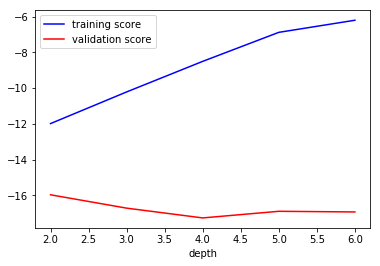

In [42]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

model = RandomForestRegressor(n_estimators=100)

depth = [2, 3, 4, 5, 6]
train_score, val_score = validation_curve(
    model, X_train, y_train,
    param_name='max_depth', param_range=depth, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth');

In [43]:
from sklearn.model_selection import RandomizedSearchCV #does cross-validation with randomized search
#it randomized searches from whatever parameters we give it.
from sklearn.ensemble import RandomForestRegressor


param_distributions = {
    'n_estimators': [100,200], #estimators, what if we have 100 trees or 200 trees.
    'max_depth': [4,5], #range of values we want
    'criterion': ['mse', 'mae'] #it measure the quality of split. uses mean squared error and 
    #mean absolute error
}

gridsearch = RandomizedSearchCV( #we initialize it like it is a model
  RandomForestRegressor(n_jobs=1, random_state =42 ),
  param_distributions = param_distributions,
  n_iter=8, #a tradeoff between how long it takes to fix vs. no. of parameter that are chosen.
  cv=4,
  scoring ='neg_mean_absolute_error',
  verbose=10, #it shows were it is at. so it shows us. 
  return_train_score=True,
  n_jobs=-1 #easy to do in parallel, it would quite as long if not having this.
    #n_iter gives candidates.
    #cv gives the folds. 

)

gridsearch.fit(X_train, y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  4.0min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=8, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200], 'max_depth': [4, 5], 'criterion': ['mse', 'mae']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [44]:
results = pd.DataFrame(gridsearch.cv_results_)
results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
4,17.489128,0.339085,0.009879,0.001308,100,4,mae,"{'n_estimators': 100, 'max_depth': 4, 'criteri...",-51.491571,-11.026817,-12.874046,-34.476945,-27.467345,16.654979,1,-9.752221,-7.184855,-7.710101,-7.296891,-7.986017,1.038311
5,34.906761,0.550902,0.015788,0.000569,200,4,mae,"{'n_estimators': 200, 'max_depth': 4, 'criteri...",-47.817537,-10.976653,-12.243749,-40.326863,-27.841200,16.451742,2,-9.780399,-7.158264,-7.651587,-7.390512,-7.995190,1.045360
6,20.062872,0.676027,0.009235,0.000028,100,5,mae,"{'n_estimators': 100, 'max_depth': 5, 'criteri...",-61.589698,-10.680194,-12.742922,-44.690890,-32.425926,21.571117,3,-8.933213,-6.347115,-7.105675,-6.590081,-7.244021,1.012989
7,39.059546,0.586530,0.016474,0.000690,200,5,mae,"{'n_estimators': 200, 'max_depth': 5, 'criteri...",-57.863707,-10.733973,-12.608783,-52.461457,-33.416980,21.839382,4,-9.091872,-6.340500,-7.069155,-6.595943,-7.274367,1.081411
0,1.048878,0.007746,0.008792,0.000154,100,4,mse,"{'n_estimators': 100, 'max_depth': 4, 'criteri...",-71.791839,-12.438987,-13.238043,-51.407443,-37.219078,25.425029,5,-11.992733,-7.490011,-9.745178,-8.457288,-9.421302,1.686443
2,1.278301,0.012269,0.008884,0.000153,100,5,mse,"{'n_estimators': 100, 'max_depth': 5, 'criteri...",-77.040340,-11.717197,-12.374281,-52.168149,-38.324992,27.712476,6,-10.395906,-6.195893,-8.747859,-7.122825,-8.115621,1.602375
3,2.557331,0.025838,0.015070,0.000215,200,5,mse,"{'n_estimators': 200, 'max_depth': 5, 'criteri...",-73.148841,-11.997733,-12.082631,-60.317232,-39.386609,27.720196,7,-10.534684,-6.268301,-8.771899,-7.199607,-8.193623,1.620949
1,2.092522,0.015272,0.014949,0.000614,200,4,mse,"{'n_estimators': 200, 'max_depth': 4, 'criteri...",-73.023166,-12.817778,-13.005921,-66.197071,-41.260984,28.451754,8,-12.471577,-7.731511,-9.885047,-8.545822,-9.658489,1.796946


In [45]:
(gridsearch.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [47]:
gridsearch.feature_importances_

AttributeError: 'RandomizedSearchCV' object has no attribute 'feature_importances_'

In [48]:
y_pred_proba = gridsearch.predict(X_test)



In [50]:
len(y_pred_proba)

994

In [52]:
y_test.shape

(994,)

In [58]:
submission = pd.DataFrame({'Date': X_test['vix_move'], 'Ratio': y_pred_proba})

submission.head()

,Date,Ratio
1606,-0.056669,11.853602
1607,-0.094554,5.152711
1608,-0.028794,21.169536
1609,0.067489,125.099793
1610,0.104613,5.427371


In [60]:
filename = 'Predictions.pk1'

submission.to_pickle(filename)

print('saved file:' + filename)

saved file:Predictions.pk1
